# National longitudal survery (NLS) dataset

In [1]:
import torch
import confounding_robust_inference as cri

In [2]:
from matplotlib import pyplot as plt

plt.style.use("seaborn-whitegrid")
from matplotlib.cm import tab10

/tmp/ipykernel_3603692/711566762.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
# setup toy policy and data
_ = torch.random.manual_seed(0)
TORCH_DTYPE = cri.utils.types.get_default_torch_dtype()
beta = torch.zeros((8,), dtype=TORCH_DTYPE)
policy = cri.policies.ATEPolicy(base_treatment=0, target_treatment=1)
data = cri.data.NLSDataDornGuo2022()
Y, T, X, _, p_t, _ = data.sample()

## Non-robust policy value

In [4]:
# Union membership (T) might positively impact the wage (Y)!
hajek_estimator = cri.estimators.IPWEstimator()
hajek_estimator.fit(Y, T, X, p_t, policy)
hajek_estimator.predict()

tensor(0.0716, dtype=torch.float64)

## Robust policy value

In [5]:
# But if we consider possibility of confounding, union membership (T) may negatively affect the wage (Y)...
estimator = cri.estimators.KCMCEstimator(const_type="Tan_box", Gamma=1.5, D=10)
estimator.fit(Y, T, X, p_t, policy)
estimator.predict()

tensor(-0.0466, dtype=torch.float64)

## Visualize the tightness of the lower/upper-bounds

In [6]:
def get_lower_bound_ci(Gamma):
    estimator = cri.estimators.KCMCEstimator(const_type="Tan_box", Gamma=Gamma, D=10)
    estimator.fit(Y, T, X, p_t, policy)
    return estimator.predict_ci()


def get_upper_bound_ci(Gamma):
    estimator = cri.estimators.KCMCEstimator(const_type="Tan_box", Gamma=Gamma, D=10)
    estimator.fit(-Y, T, X, p_t, policy)
    low, high = estimator.predict_ci()
    return -high, -low

In [7]:
Gammas = [1 + i / 10 for i in range(11)]
lower_bound_cis = [get_lower_bound_ci(Gamma) for Gamma in Gammas]
upper_bound_cis = [get_upper_bound_ci(Gamma) for Gamma in Gammas]

In [8]:
lower_bounds = [(l + h) / 2 for (l, h) in lower_bound_cis]
upper_bounds = [(l + h) / 2 for (l, h) in upper_bound_cis]
lower_bound_cis_high = [h for (l, h) in lower_bound_cis]
upper_bound_cis_high = [h for (l, h) in upper_bound_cis]
lower_bound_cis_low = [l for (l, h) in lower_bound_cis]
upper_bound_cis_low = [l for (l, h) in upper_bound_cis]

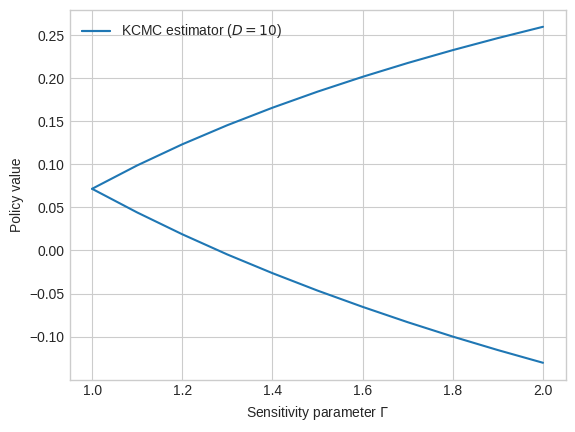

In [9]:
lower_line = plt.plot(Gammas, lower_bounds, color=tab10(0))[0]
upper_line = plt.plot(Gammas, upper_bounds, color=tab10(0))[0]

plt.legend(
    [(lower_line, upper_line)],
    ["KCMC estimator ($D=10$)"],
)
plt.xlabel(r"Sensitivity parameter $\Gamma$")
plt.ylabel(r"Policy value")
plt.savefig("fig/nls_data_bound_tightness.pdf")